# Import Library

In [1]:
# Libraries yang digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tq
import seaborn as sns

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan Peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Loading + EDA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# unzip dataset
!unzip "/content/drive/MyDrive/dataset meatwatch/dataset meatwatch.zip" -d dataset_folder

Archive:  /content/drive/MyDrive/dataset meatwatch/dataset meatwatch.zip
   creating: dataset_folder/meatwatch dataset/
   creating: dataset_folder/meatwatch dataset/Segar/
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (1).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (10).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (100).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (101).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (102).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (103).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (104).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (105).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (106).jpg  
  inflating: dataset_folder/meatwatch dataset/Segar/fresh-chicken (107).jpg  
  inflating: dataset_folder/meatwatch dataset/Sega

In [4]:
# menghitung jumlah dataset pada setiap class
dataset_path = 'dataset_folder/meatwatch dataset'

class_count= {}
for class_name in os.listdir(dataset_path):
  class_dir = os.path.join(dataset_path, class_name)
  if os.path.isdir(class_dir):
    class_count[class_name] = len(os.listdir(class_dir))

for class_name, count in class_count.items():
  print(f"Class: {class_name}, Jumlah Data: {count}")

Class: Tidak Segar, Jumlah Data: 1686
Class: Segar, Jumlah Data: 1675


# Data Preprocessing + Splitting

In [5]:
# splitting dataset (train, val, test)
dataset_path = 'dataset_folder/meatwatch dataset'
base_output = 'dataset_split'

split_ratio = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

# membuat direktori base_output
for split in ['train', 'val', 'test']:
  for class_name in os.listdir(dataset_path):
    class_splith_path = os.path.join(base_output, split, class_name)
    os.makedirs(class_splith_path, exist_ok=True)

# proses setiap class
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        total = len(all_images)
        train_end = int(total * split_ratio['train'])
        val_end = train_end + int(total * split_ratio['val'])

        train_imgs = all_images[:train_end]
        val_imgs = all_images[train_end:val_end]
        test_imgs = all_images[val_end:]

        # Copy ke folder tujuan
        for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(base_output, split, class_name, img)
                shutil.copyfile(src, dst)

In [6]:
# Detail komposisi Splitting Data
base_dir = 'dataset_split'
img_size = (224, 224)
batch_size = 32

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

#Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

Found 2688 files belonging to 2 classes.
Found 335 files belonging to 2 classes.
Found 338 files belonging to 2 classes.


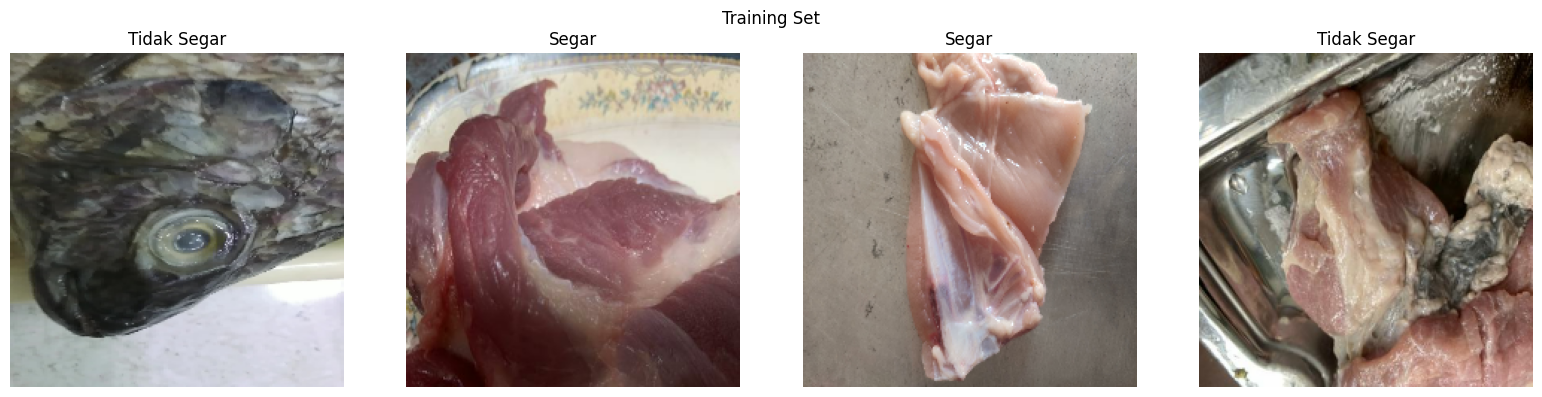

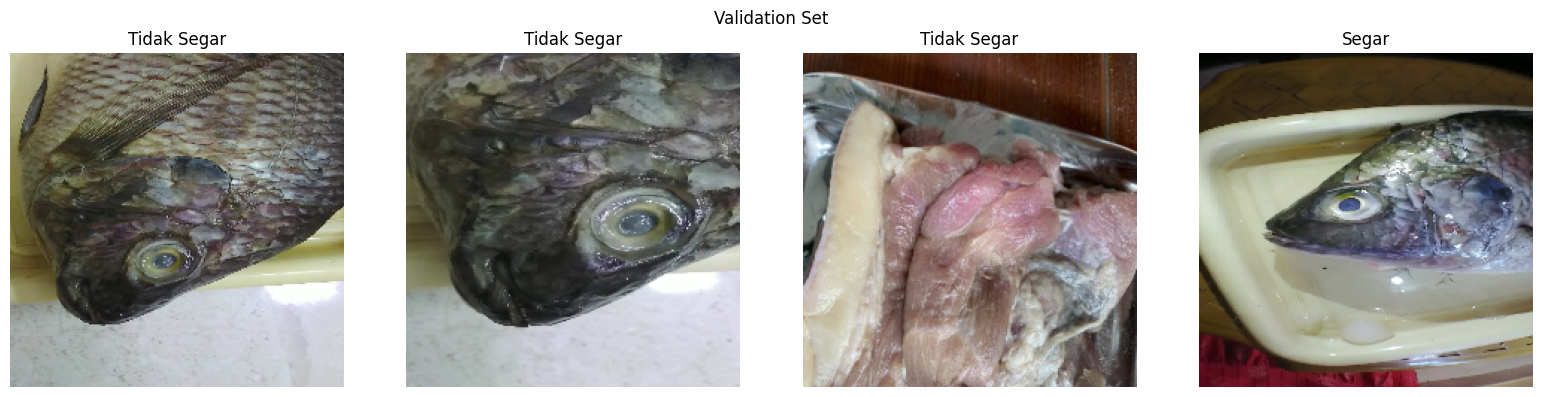

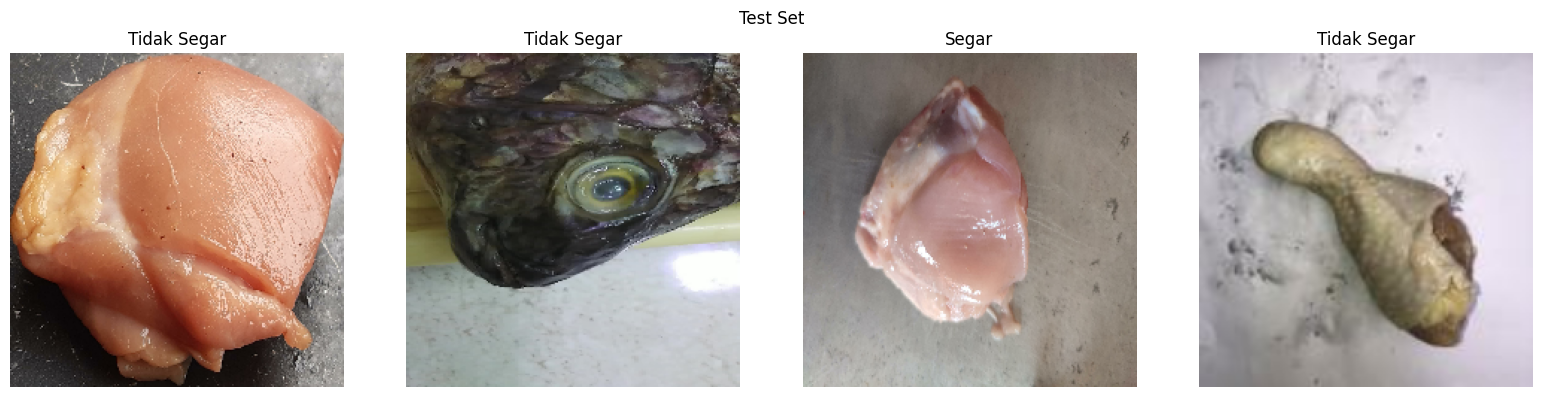

In [12]:
# Visualisasi sample foto pada masing masing split
class_names = train_ds.class_names

def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(16, 4))

    for images, labels in dataset.take(1):
        for i in range(4):
            ax = plt.subplot(1, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Panggil untuk masing-masing split
show_images(train_ds, title="Training Set")
show_images(val_ds, title="Validation Set")
show_images(test_ds, title="Test Set")

# Modelling

In [ ]:
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomTranslation(0.2, 0.2),
#     layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2)
# ])

In [ ]:
# # model CNN sederhana
# model = models.Sequential([
#     layers.Rescaling(1./255, input_shape=(224, 224, 3)),

#     layers.Conv2D(32, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),

#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),

#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.MaxPooling2D(2,2),

#     layers.Dropout(0.5),
#     layers.Flatten(),

#     layers.Dense(128, activation='relu'),
#     layers.Dense(2, activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

In [ ]:
# # Load base model EfficientNetB0 tanpa top layer (fully connected-nya)
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze semua layer EfficientNetB0 agar bobot pretrained tidak ikut di-train dulu
# base_model.trainable = False

# # Buat model di atas base EfficientNetB0
# model = models.Sequential([
#     layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(2, activation='softmax')
# ])

# # Compile model
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Lihat summary model
# model.summary()

In [13]:
# Load base model MobileNetV2 tanpa top layer (fully connected-nya)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer MobileNetV2 agar bobot pretrained tidak ikut di-train dulu
base_model.trainable = False

# Buat model di atas base MobileNetV2
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Lihat summary model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# from tensorflow.keras.applications import ResNet50V2

# # Load base model ResNet50V2 tanpa top layer (fully connected-nya)
# base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze semua layer ResNet50V2 agar bobot pretrained tidak ikut di-train dulu
# base_model.trainable = False

# # Buat model di atas base ResNet50V2
# model = models.Sequential([
#     # data_augmentation,
#     layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(2, activation='softmax')
# ])

# # # Compile model
# # model.compile(
# #     optimizer=Adam(learning_rate=0.0001),
# #     loss=tfa.losses.SigmoidFocalCrossEntropy(),
# #     metrics=['accuracy']
# # )

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,886 (91.90 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95 and logs.get('accuracy')>0.95):
      print("\nAkurasi telah mencapai > 95%!")
      self.model.stop_training = True

callbacks = myCallback()

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 385ms/step - accuracy: 0.6664 - loss: 0.6862 - val_accuracy: 0.9612 - val_loss: 0.1885
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.8432 - loss: 0.3320 - val_accuracy: 0.9761 - val_loss: 0.1134
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 0.9007 - loss: 0.2274 - val_accuracy: 0.9821 - val_loss: 0.0831
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 276ms/step - accuracy: 0.9260 - loss: 0.2028 - val_accuracy: 0.9851 - val_loss: 0.0685
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.9444 - loss: 0.1513 - val_accuracy: 0.9851 - val_loss: 0.0589
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9535 - loss: 0.1262
Akurasi telah mencapai > 95%!
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 263ms/step - accuracy: 0.9536 - loss: 0.1263 - val_accuracy: 0.9910 - val_loss: 0.0495


# Evaluasi Model

In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Akurasi di test set: {test_acc:.2%}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - accuracy: 0.9894 - loss: 0.0465
Akurasi di test set: 99.11%


In [17]:
# Ambil label aslinya
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [18]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Segar       0.98      1.00      0.99       168
 Tidak Segar       1.00      0.98      0.99       170

    accuracy                           0.99       338
   macro avg       0.99      0.99      0.99       338
weighted avg       0.99      0.99      0.99       338



# Visualisasi Model

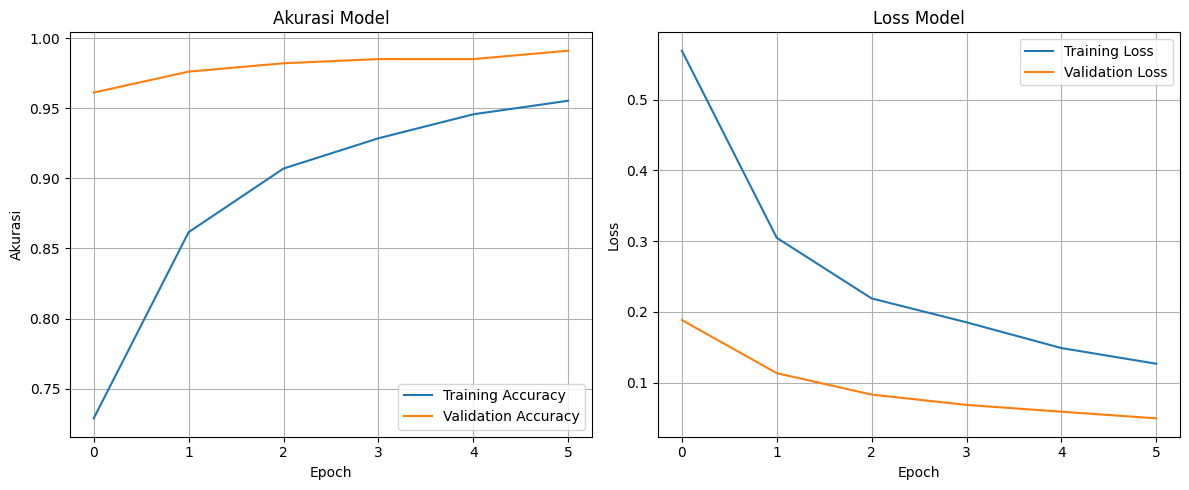

In [19]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

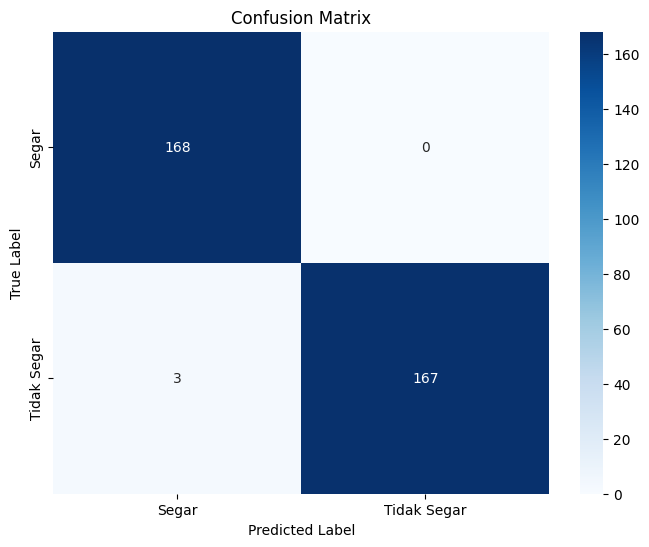

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Konversi Model

In [21]:
# Konversi model ke .h5
model.save('model.h5')

# Inference Model

In [25]:
def predict_images(model, image_paths, class_names, target_size=(224, 224)):
    """
    Melakukan inferensi gambar satuan atau batch menggunakan model TensorFlow.

    Parameters:
        model (tf.keras.Model): model yang sudah diload (Sequential atau Functional API)
        image_paths (list): list path gambar (string)
        class_names (list): list nama-nama class sesuai urutan waktu training
        target_size (tuple): ukuran target image

    Returns:
        list of tuple: (image_path, predicted_label, probability)
    """
    results = []

    for img_path in image_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        # Normalisasi dilakukan oleh layer Rescaling di model

        # Lakukan prediksi menggunakan metode predict() dari model
        predictions = model.predict(img_array)

        # Ambil probabilitas dan label prediksi
        pred_probs = predictions[0]
        pred_idx = np.argmax(pred_probs)
        pred_label = class_names[pred_idx]
        pred_prob = pred_probs[pred_idx]

        results.append((img_path, pred_label, pred_prob))

    return results

In [27]:
# Load model dari file .h5
model = keras.models.load_model("model.h5")

# class names dari training dataset
class_names = ['Segar', 'Tidak Segar']

# Gambar yang mau diprediksi
image_paths = [
    "ikan-segar.jpg",
    "sapi-busuk.jpg",
    "ayam-busuk.jpg",
    "sapi-segar.jpg"
]

# Prediksi
results = predict_images(model, image_paths, class_names)

# Tampilkan hasil
for img_path, label, prob in results:
    print(f"{os.path.basename(img_path)} → Prediksi: {label} (Prob: {prob:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
ikan-segar.jpg → Prediksi: Segar (Prob: 1.00)
sapi-busuk.jpg → Prediksi: Tidak Segar (Prob: 0.99)
ayam-busuk.jpg → Prediksi: Tidak Segar (Prob: 0.98)
sapi-segar.jpg → Prediksi: Segar (Prob: 0.99)


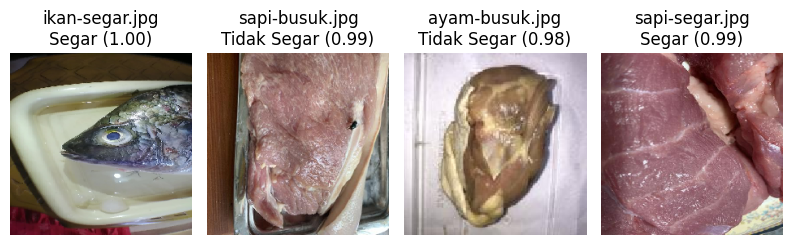

In [28]:
# Atur ukuran plot
plt.figure(figsize=(10, 8))

# Loop tiap gambar + hasil prediksi
for i, (img_path, label, prob) in enumerate(results):
    # Baca gambar
    img = image.load_img(img_path, target_size=(224, 224))

    # Plot di subplot
    plt.subplot(3, 5, i+1)  # (baris, kolom, index)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{os.path.basename(img_path)}\n{label} ({prob:.2f})")

plt.tight_layout()
plt.show()